<a href="https://colab.research.google.com/github/Alexandre77777/neural_networks/blob/main/9.%20%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9%20%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%E2%84%969_%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Теория №9. Развертывание моделей глубокого обучения**

В данном учебном блокноте представлен полный жизненный цикл разработки моделей глубокого обучения для задач регрессии и классификации. Начиная со сбора и подготовки данных, проводится обучение нейронных сетей с использованием библиотеки Keras. Лучшая модель выбирается на основе вычисленных метрик качества. Далее модель сохраняется, развёртывается на сервере и разрабатывается интерфейс для взаимодействия с ней. Этот процесс охватывает все этапы жизненного цикла модели глубокого обучения: от предварительной обработки данных до интеграции модели в приложение и её развёртывания на сервере.

# **I. Решение задачи регрессии на примере датасета California Housing**

## **1. Установка необходимых зависимостей**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle
import os

## **2. Загрузка набора данных. Формирование обучающей и тестовой выборок**

In [ ]:
data = fetch_california_housing(as_frame=True)
df = data.frame
X = df.drop(columns=[data.target_names[0]])
y = df[data.target_names[0]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Нормализация данных для нейронных сетей
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train.iloc[0]

,14196
MedInc,3.259600
HouseAge,33.000000
AveRooms,5.017657
AveBedrms,1.006421
Population,2300.000000
AveOccup,3.691814
Latitude,32.710000
Longitude,-117.030000


## **3. Инициализация метрик для оценки качества обучения моделей**

In [ ]:
def mean_squared_percentage_error(y_true, y_pred):
    # MSPE
    return np.mean((y_true - y_pred) ** 2 / (y_true + 1e-9) ** 2) * 100

def mean_absolute_percentage_error(y_true, y_pred):
    # MAPE
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    # SMAPE
    return 100 * np.mean(
        2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
    )

def mean_relative_error(y_true, y_pred):
    # MRE
    return np.mean(np.abs(y_true - y_pred) / (y_true + 1e-9))

def rmsle(y_true, y_pred):
    # RMSLE
    return np.sqrt(np.mean((np.log1p(y_pred + 1e-9) - np.log1p(y_true + 1e-9))**2))

def adjusted_r2_score(r2, n, p):
    """
    Расчёт скорректированного R².
    r2:   R²
    n:    число наблюдений
    p:    число признаков
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def get_metrics(y_true, y_pred, n, p):
    # MAE
    mae_ = mean_absolute_error(y_true, y_pred)
    # MSE
    mse_ = mean_squared_error(y_true, y_pred)
    # RMSE
    rmse_ = np.sqrt(mse_)
    # R^2
    r2_ = r2_score(y_true, y_pred)
    # MAPE
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    # MSPE
    mspe_ = mean_squared_percentage_error(y_true, y_pred)
    # SMAPE
    smape_ = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    # MRE
    mre_ = mean_relative_error(y_true, y_pred)
    # RMSLE
    rmsle_ = rmsle(y_true, y_pred)
    # Adjusted R²
    adj_r2_ = adjusted_r2_score(r2_, n, p)
    return {
        "MAE": mae_,
        "MAPE": mape_,
        "MSE": mse_,
        "RMSE": rmse_,
        "R2": r2_,
        "MSPE": mspe_,
        "SMAPE": smape_,
        "MRE": mre_,
        "RMSLE": rmsle_,
        "Adjusted R2": adj_r2_
    }

## **4. Создание моделей глубокого обучения в Keras**

In [ ]:
def create_dense_model(input_dim, name="dense_model"):
    """Создание простой полносвязной нейронной сети"""
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ], name=name)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_deep_model(input_dim, name="deep_model"):
    """Создание глубокой нейронной сети с dropout слоями"""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ], name=name)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_residual_model(input_dim, name="residual_model"):
    """Создание модели с остаточными связями"""
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)

    # Остаточный блок 1
    block_1 = layers.Dense(64, activation='relu')(x)
    block_1 = layers.Dense(64, activation='relu')(block_1)
    x = layers.add([x, block_1])

    # Остаточный блок 2
    block_2 = layers.Dense(64, activation='relu')(x)
    block_2 = layers.Dense(64, activation='relu')(block_2)
    x = layers.add([x, block_2])

    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
# Словарь с моделями
models = {
    "dense_model": create_dense_model(X_train_scaled.shape[1]),
    "deep_model": create_deep_model(X_train_scaled.shape[1]),
    "residual_model": create_residual_model(X_train_scaled.shape[1])
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **5. Обучение моделей глубокого обучения с вычислением метрик**

In [ ]:
epochs = 50
batch_size = 32
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

results = {}
for name, model in models.items():
    # Обучаем модель
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Предсказания на тестовых данных
    y_pred = model.predict(X_test_scaled).flatten()

    # Подсчёт метрик
    metrics = get_metrics(y_test, y_pred, n=len(y_test), p=X_train_scaled.shape[1])
    results[name] = metrics

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.3880 - mae: 1.1147 - val_loss: 0.4454 - val_mae: 0.4762
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3933 - mae: 0.4502 - val_loss: 0.4021 - val_mae: 0.4459
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3643 - mae: 0.4285 - val_loss: 0.3879 - val_mae: 0.4378
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3420 - mae: 0.4163 - val_loss: 0.3754 - val_mae: 0.4202
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3340 - mae: 0.4066 - val_loss: 0.3567 - val_mae: 0.4174
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3121 - mae: 0.3951 - val_loss: 0.3542 - val_mae: 0.4286
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3230 - mae: 0.3958 - val_loss: 0.3430 - val_mae: 0.4055
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3041 - mae: 0.3858 - val_loss: 0.3338 - val_mae: 0.4004
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - 

## **6. Оценка точности и выбор лучшей модели**

In [ ]:
results_df = pd.DataFrame(results).T  # Переводим в DataFrame для удобства
results_df = results_df.sort_values(by='R2', ascending=False)

print("Результаты по всем моделям:\n")
display(results_df.style.format("{:.3f}"))

# Выбор лучшей модели по R2
best_model_name = results_df["R2"].idxmax()
print(f"\nЛучшая модель по R2: {best_model_name}")
best_model = models[best_model_name]

Результаты по всем моделям:



,MAE,MAPE,MSE,RMSE,R2,MSPE,SMAPE,MRE,RMSLE,Adjusted R2
dense_model,0.356,20.071,0.278,0.527,0.788,16.875,18.121,0.201,0.159,0.788
residual_model,0.352,19.406,0.278,0.528,0.788,18.367,17.691,0.194,0.159,0.787
deep_model,0.387,22.444,0.306,0.554,0.766,21.396,19.877,0.224,0.168,0.766



Лучшая модель по R2: dense_model


## **7. Сохранение лучшей модели в формате Keras**

In [ ]:
model_path = "best_keras_model.h5"
model_dir = ''


# Сохраняем модель в формате SavedModel (TensorFlow)
best_model.save(model_path)

# Сохраняем scaler для последующего использования
with open(os.path.join(model_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print(f"\nЛучшая модель сохранена в директории {model_dir}")


Лучшая модель сохранена в директории 


## **8. Загрузка и использование сохраненной модели**

In [ ]:
# Загрузка модели
loaded_model = tf.keras.models.load_model(model_path, compile=False)

# Загрузка scaler
with open("scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

# Пример использования (на тех же данных что и в оригинальном примере)
X_new = np.array([[8.0, 20.0, 6.0, 1.0, 1000.0, 3.0, 34.19, -118.31]])
X_new_scaled = loaded_scaler.transform(X_new)

# Предсказываем
prediction = loaded_model.predict(X_new_scaled)
print(f"Предсказание цены: {prediction[0][0]}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Предсказание цены: 3.5646753311157227


## **9. Реализация веб-приложения с использованием Gradio для работы с моделью**

In [ ]:
%%capture
!pip install gradio

In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow import keras
import pickle
import numpy as np
import os

# Загрузка модели и скейлера
model_path = "best_keras_model.h5"
model = keras.models.load_model(model_path)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Функция предсказания
def predict_price(
    MedInc,
    HouseAge,
    AveRooms,
    AveBedrms,
    Population,
    AveOccup,
    Latitude,
    Longitude
):
    """
    Функция принимает значения признаков, масштабирует их
    и возвращает предсказание цены.
    """
    # Формируем numpy-массив из входных данных
    X_new = np.array([[MedInc, HouseAge, AveRooms, AveBedrms,
                     Population, AveOccup, Latitude, Longitude]])

    # Применяем масштабирование
    X_scaled = loaded_scaler.transform(X_new)

    # Получаем предсказание
    prediction = loaded_model.predict(X_scaled)

    return float(prediction[0][0])

# Создаём интерфейс Gradio
interface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Медианный доход (MedInc)"),
        gr.Number(label="Средний возраст жилья (HouseAge)"),
        gr.Number(label="Среднее кол-во комнат (AveRooms)"),
        gr.Number(label="Среднее кол-во спален (AveBedrms)"),
        gr.Number(label="Население (Population)"),
        gr.Number(label="Среднее кол-во человек в доме (AveOccup)"),
        gr.Number(label="Широта (Latitude)"),
        gr.Number(label="Долгота (Longitude)")
    ],
    outputs="text",
    title="Прогноз стоимости недвижимости",
    description=(
        "Введите параметры и нажмите 'Submit'. "
        "Модель вернёт предсказанную стоимость."
    )
)

# Запуск интерфейса Gradio
interface.launch(share=True)

Предсказание цены: [3.7643755]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## **10. Развертывание модели Keras на сервере с использованием FastAPI**

**(Весь процесс от начала и до конца рассматривался на паре, ниже привожу его структурированный пересказ)**

Разработка веб-приложения, которое служит интерфейсом для обученной модели, включает несколько этапов:

1. **Создание API для модели и развёртывание его на Render.com**
2. **Разработка графического интерфейса с использованием Streamlit**
3. **Развёртывание Streamlit приложения на платформе Streamlit**

Все этапы проводятся в десткопной среде Pycharm/VS Code, затем готовый проект пушится на GitHub

### **1. Создание API для модели и развёртывание его на Render.com**


#### **Файл `main.py`**

```python
from fastapi import FastAPI
import tensorflow as tf
from tensorflow import keras
import pickle
import numpy as np
from pydantic import BaseModel
import os

app = FastAPI()
```

- **Импорт необходимых библиотек:**
  - `FastAPI` для создания веб-приложения API.
  - `tensorflow` и `keras` для работы с нейросетевой моделью.
  - `pickle` для загрузки сохранённого скейлера.
  - `numpy` для работы с числовыми массивами.
  - `pydantic` для валидации входных данных.
  - `os` для работы с путями к файлам.

- **Инициализация приложения:** Создаём экземпляр приложения `FastAPI`.

```python
# Загрузка модели и скейлера
model_path = "best_keras_model.h5"
model = keras.models.load_model(model_path)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
```

- **Загрузка обученной модели и скейлера:**
  - Указываем директорию/файл `best_keras_model`, где хранится модель/с моделью.
  - Используем `keras.models.load_model` для загрузки модели TensorFlow.
  - Открываем файл `scaler.pkl` из той же директории для загрузки скейлера.
  - Используем `pickle.load` для десериализации скейлера.

```python
class InputData(BaseModel):
    MedInc: float
    HouseAge: float
    AveRooms: float
    AveBedrms: float
    Population: float
    AveOccup: float
    Latitude: float
    Longitude: float
```

- **Определение модели входных данных:**
  - Создаём класс `InputData`, наследующий от `BaseModel`, который описывает структуру ожидаемых данных от клиента.
  - Каждый атрибут соответствует одному из признаков модели и имеет тип `float`.

```python
@app.post('/predict')
async def predict(input_data: InputData):
    # Преобразуем входные данные в numpy массив
    X_new = np.array([[
        input_data.MedInc,
        input_data.HouseAge,
        input_data.AveRooms,
        input_data.AveBedrms,
        input_data.Population,
        input_data.AveOccup,
        input_data.Latitude,
        input_data.Longitude
    ]])
```

- **Создание маршрута для предсказаний:**
  - Используем декоратор `@app.post('/predict')` для создания эндпоинта `/predict`, который будет обрабатывать POST-запросы.
  - Функция `predict` принимает объект `input_data` типа `InputData`.
  - Собираем входные данные в numpy-массив `X_new`, который затем подаётся на вход модели.

```python
    # Применяем скейлер
    X_scaled = scaler.transform(X_new)
```

- **Масштабирование данных:**
  - Применяем загруженный скейлер к входным данным для нормализации признаков.
  - Результат сохраняем в переменную `X_scaled`.

```python
    # Получаем предсказание
    prediction = model.predict(X_scaled)
```

- **Получение прогноза:**
  - Используем загруженную Keras-модель для предсказания цены на основе масштабированных данных.

```python
    return {"prediction": float(prediction[0][0])}
```

- **Возвращение результата:**
  - Возвращаем прогноз в формате JSON, извлекая значение из вложенного массива и преобразуя результат в `float` для обеспечения сериализации.

**Файл `requirements.txt`**

```
fastapi==0.103.0
numpy
tensorflow==2.18.0
uvicorn==0.23.2
scikit-learn==1.6.1
```

- **Зависимости проекта:**
  - Указываем необходимые библиотеки и их версии для корректной работы приложения.



Для запуска API локально выполните:

```
uvicorn main:app --reload
```

**Развёртывание на Render.com**

1. **Регистрация и настройка проекта:**
   - Зарегистрироваться на [Render.com](https://render.com).
   - Создать новый веб-сервис, указав репозиторий с вашим проектом.
   - Указать ветку и команду запуска (например, `uvicorn main:app --host 0.0.0.0 --port $PORT`).

2. **Настройка зависимостей:**
   - Render.com автоматически установит зависимости из файла `requirements.txt`.

3. **Развёртывание:**
   - Запустить процесс развёртывания и дождаться его завершения.

Теперь API доступен по адресу, предоставленному Render.com.

- Пример использования API:

In [ ]:
import requests

# URL API
url = 'https://california-regression.onrender.com/predict'

# Сбор данных от пользователя
print("Введите параметры для прогноза цены на жильё.")

MedInc = float(input("Медианный доход: "))
HouseAge = float(input("Средний возраст жилья: "))
AveRooms = float(input("Общее кол-во комнат: "))
AveBedrms = float(input("Общее кол-во спален: "))
Population = float(input("Население: "))
AveOccup = float(input("Кол-во домохозяйств: "))
Latitude = float(input("Широта: "))
Longitude = float(input("Долгота: "))

# Создание словаря с данными
data = {
    "MedInc": MedInc,
    "HouseAge": HouseAge,
    "AveRooms": AveRooms,
    "AveBedrms": AveBedrms,
    "Population": Population,
    "AveOccup": AveOccup,
    "Latitude": Latitude,
    "Longitude": Longitude
}

# Отправка POST-запроса к API
response = requests.post(url, json=data)

# Обработка ответа
if response.status_code == 200:
    try:
        result = response.json()
        prediction = result.get('prediction')
        if prediction is not None:
            print(f'Прогнозируемая цена: {prediction*1000:.2f}$')
        else:
            print("Ошибка! Ответ API не содержит прогноз!")
    except ValueError:
        print("Ошибка! Ответ API не является валидным JSON!")
else:
    print(f"Ошибка! API вернул статус: {response.status_code}")

Введите параметры для прогноза цены на жильё.
Медианный доход: 34
Средний возраст жилья: 3
Общее кол-во комнат: 4
Общее кол-во спален: 2
Население: 30000
Кол-во домохозяйств: 12
Широта: 54
Долгота: 36
Прогнозируемая цена: 3571.65$


### **2. Разработка графического интерфейса с использованием Streamlit**

#### **Файл `app.py`**


```python
import streamlit as st
import requests
import json
import numpy as np
import pickle
import os

# Загрузка скейлера
with open("best_keras_model/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

st.title("Прогноз цены на жильё с использованием нейронной сети Keras")

# API для модели Keras
API_URL = "http://localhost:8000/predict"  # FastAPI URL
```

- **Импорт необходимых библиотек:**
  - `streamlit` для создания интерактивного веб-приложения.
  - `requests` для отправки HTTP-запросов к API.
  - `json` для работы с JSON-данными.
  - `numpy` для операций с числовыми массивами.
  - `pickle` для загрузки сохранённого скейлера.
  - `os` для работы с путями к файлам.

- **Загрузка скейлера:**
  - Открываем файл скейлера из директории `best_keras_model`.
  - Используем `pickle.load` для десериализации скейлера.

- **Настройка интерфейса:**
  - С помощью `st.title` отображаем заголовок приложения.
  - Указываем URL для доступа к API, запущенному на локальном сервере.

```python
# Вводные данные
MedInc = st.number_input("Медианный доход", value=3.0)
HouseAge = st.number_input("Средний возраст жилья", value=3.0)
AveRooms = st.number_input("Среднее кол-во комнат", value=3.0)
AveBedrms = st.number_input("Среднее кол-во спален", value=3.0)
Population = st.number_input("Население", value=1500.0)
AveOccup = st.number_input("Среднее кол-во человек в доме", value=500.0)
Latitude = st.number_input("Широта", value=37.88)
Longitude = st.number_input("Долгота", value=-122.33)
```

- **Сбор входных данных:**
  - Создаём ряд полей ввода с помощью `st.number_input`.
  - Для каждого поля указываем понятную метку и значение по умолчанию.
  - Собираем все ключевые параметры, влияющие на прогноз цены жилья.

```python
if st.button("Получить прогноз"):
    # Подготовка данных для запроса
    data = {
        "MedInc": MedInc,
        "HouseAge": HouseAge,
        "AveRooms": AveRooms,
        "AveBedrms": AveBedrms,
        "Population": Population,
        "AveOccup": AveOccup,
        "Latitude": Latitude,
        "Longitude": Longitude
    }
```

- **Обработка нажатия кнопки:**
  - С помощью `st.button` создаём кнопку запуска прогнозирования.
  - При активации кнопки формируем словарь `data` с данными для отправки на сервер.
  - Структура словаря соответствует ожидаемому формату API.

```python
    # Отправка запроса к API
    try:
        response = requests.post(API_URL, json=data)
        
        if response.status_code == 200:
            result = response.json()
            prediction = result.get('prediction')
            st.success(f'Прогнозируемая цена: {prediction*100000:.2f}$')
            
            # Визуализация результата
            st.subheader('Визуализация прогноза')
            st.bar_chart({"Прогноз": [prediction]})
        else:
            st.error(f"Ошибка API: {response.status_code}")
    except Exception as e:
        st.error(f"Ошибка при отправке запроса: {str(e)}")
```

- **Взаимодействие с API и обработка результатов:**
  - Используем конструкцию `try-except` для обработки возможных ошибок соединения.
  - Отправляем POST-запрос к указанному API с данными в формате JSON.
  - Проверяем успешность запроса по коду ответа (200 означает успех).
  - При успешном ответе:
    - Извлекаем прогноз из ответа.
    - Отображаем результат, умножая на 100000 для получения реальной цены в долларах.
    - Создаём визуализацию прогноза с помощью `st.bar_chart`.
  - При ошибке API или исключении выводим соответствующее сообщение с деталями проблемы.

Для запуска Streamlit приложения выполните:

```
streamlit run app.py
```

### **3. Развёртывание Streamlit приложения на платформе Streamlit**



1. **Регистрация на Streamlit Sharing:**
   - Перейдите на [streamlit.io](https://streamlit.io) и зарегистрируйтесь.
   - Получите доступ к Streamlit Community Cloud (ранее Streamlit Sharing).

2. **Развёртывание приложения:**
   - На панели управления Streamlit создайте новое приложение, указав ссылку на ваш репозиторий и путь к файлу `app.py`.
   - Убедитесь, что в `requirements.txt` указаны все необходимые зависимости.

3. **Запуск и тестирование:**
   - Запустите приложение и убедитесь, что оно корректно работает.
   - Проверьте ввод данных и получение прогноза.

- Ссылка на развернутое приложение, реализованное на паре: https://californiaregression-kfbybrncfrpkju36p9kwn4.streamlit.app/

### **Структура репозитория с проектом**



```
app.py
best_regression_model
main.py
requirements.txt
```

- **`app.py`** — код Streamlit приложения (клиентская часть).
- **`main.py`** — код FastAPI приложения (серверная часть).
- **`best_regression_model.h5`** — файл с сохранённой моделью и пайплайном предобработки.
- **`requirements.txt`** — список зависимостей для установки необходимых библиотек.

### **Выводы:**



В результате мы разработали веб-приложение, которое позволяет пользователю вводить параметры жилья и получать прогнозируемую цену. Процесс разработки включал:

- **Создание API с использованием FastAPI:** Мы создали серверное приложение, которое загружает обученную модель, принимает входные данные и возвращает предсказание.

- **Развёртывание API на Render.com:** Это позволяет сделать наш API доступным из интернета, чтобы клиентское приложение могло отправлять к нему запросы.

- **Разработка клиентского приложения с использованием Streamlit:** Мы создали удобный графический интерфейс, где пользователь может вводить данные и получать результаты.

- **Развёртывание Streamlit приложения:** Это делает наше приложение доступным для конечных пользователей через веб-браузер.

# **II. Классификация изображений**

## **1. Установка необходимых зависимостей**

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

## **2. Загрузка набора данных. Формирование обучающей и тестовой выборок**

In [6]:
# Загрузка датасета MNIST
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Преобразование изображений в правильный формат для CNN
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

# Преобразование меток в категориальный формат (one-hot encoding)
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels_cat, test_size=0.2, random_state=42
)

print(f"Размер обучающего набора: {X_train.shape}")
print(f"Размер валидационного набора: {X_val.shape}")
print(f"Размер тестового набора: {test_images.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Размер обучающего набора: (48000, 28, 28, 1)
Размер валидационного набора: (12000, 28, 28, 1)
Размер тестового набора: (10000, 28, 28, 1)


## **3. Создание моделей глубокого обучения для классификации изображений**

In [ ]:
def create_simple_cnn(input_shape=(28, 28, 1), num_classes=10, name="simple_cnn"):
    """
    Создание простой сверточной нейронной сети (CNN)
    """
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_deep_cnn(input_shape=(28, 28, 1), num_classes=10, name="deep_cnn"):
    """
    Создание глубокой сверточной нейронной сети с dropout и batch normalization
    """
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_residual_cnn(input_shape=(28, 28, 1), num_classes=10, name="residual_cnn"):
    """
    Создание сверточной нейронной сети с остаточными связями
    """
    inputs = keras.Input(shape=input_shape)

    # Первый блок
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Остаточный блок 1
    block_1 = layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2))(x)
    block_1 = layers.BatchNormalization()(block_1)
    block_1 = layers.Activation('relu')(block_1)
    block_1 = layers.Conv2D(64, (3, 3), padding='same')(block_1)
    block_1 = layers.BatchNormalization()(block_1)

    # Shortcut соединение
    shortcut = layers.Conv2D(64, (1, 1), strides=(2, 2))(x)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([block_1, shortcut])
    x = layers.Activation('relu')(x)

    # Финальная часть
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Словарь с моделями
models = {
    "simple_cnn": create_simple_cnn(),
    "deep_cnn": create_deep_cnn(),
    "residual_cnn": create_residual_cnn()
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **4. Обучение моделей глубокого обучения с вычислением метрик**

In [ ]:
import time

# Колбэк для ранней остановки
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Обучение и оценка моделей
results = {}
histories = {}

for name, model in models.items():
    print(f"Начало обучения модели: {name}")
    start_time = time.time()

    # Обучение модели
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    histories[name] = history

    end_time = time.time()
    training_time = end_time - start_time

    # Оценка модели на тестовом наборе
    test_loss, test_acc = model.evaluate(test_images, test_labels_cat, verbose=0)

    # Получение предсказаний
    y_pred_proba = model.predict(test_images)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test = np.argmax(test_labels_cat, axis=1)

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': cm,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'training_time': training_time
    }

    print(f"Модель {name} обучена. Время обучения: {training_time:.2f} секунд")
    print(f"Точность на тестовых данных: {test_acc:.4f}")
    print()

Начало обучения модели: simple_cnn
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.8514 - loss: 0.5357 - val_accuracy: 0.9755 - val_loss: 0.0818
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9782 - loss: 0.0725 - val_accuracy: 0.9847 - val_loss: 0.0505
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9872 - loss: 0.0438 - val_accuracy: 0.9843 - val_loss: 0.0500
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9899 - loss: 0.0319 - val_accuracy: 0.9884 - val_loss: 0.0377
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9929 - loss: 0.0233 - val_accuracy: 0.9883 - val_loss: 0.0368
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9931 - loss: 0.0207 - val_accuracy: 0.9891 - val_loss: 0.0387
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9957 - loss: 0.0157 - val_accuracy: 0.9896 - val_loss: 0.0381
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9

## **5. Визуализация процесса обучения моделей**

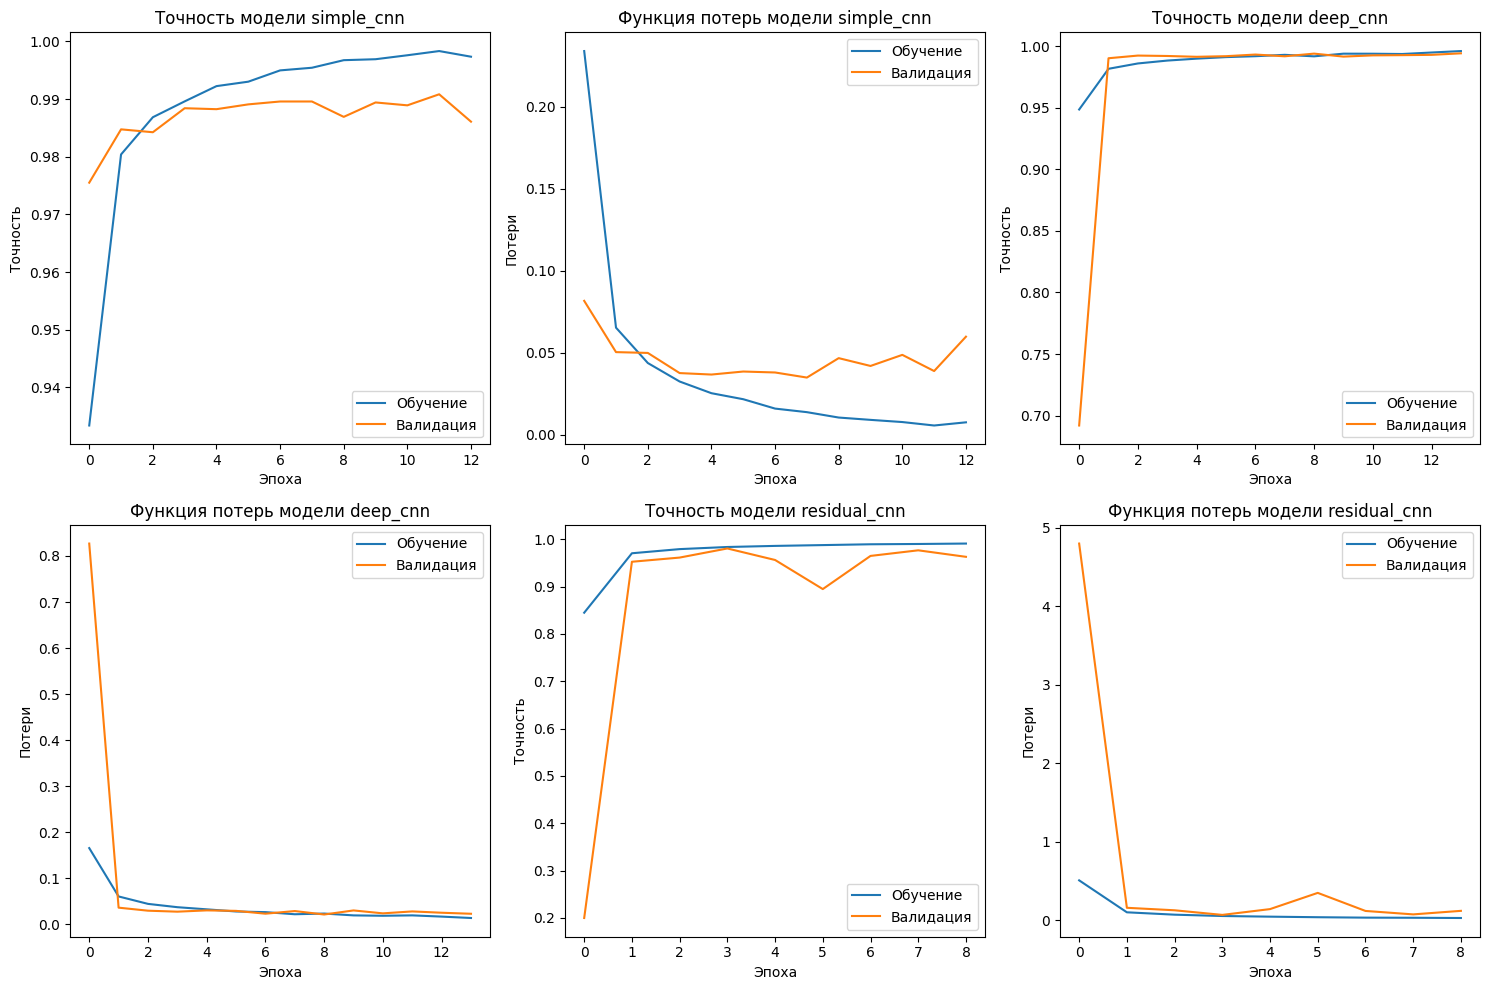

In [ ]:
# Визуализация процесса обучения для каждой модели
plt.figure(figsize=(15, 10))

for i, (name, history) in enumerate(histories.items()):
    plt.subplot(2, 3, i*2+1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Точность модели {name}')
    plt.ylabel('Точность')
    plt.xlabel('Эпоха')
    plt.legend(['Обучение', 'Валидация'], loc='lower right')

    plt.subplot(2, 3, i*2+2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Функция потерь модели {name}')
    plt.ylabel('Потери')
    plt.xlabel('Эпоха')
    plt.legend(['Обучение', 'Валидация'], loc='upper right')

plt.tight_layout()
plt.show()

## **6. Оценка точности и выбор лучшей модели**

Результаты по всем моделям:


,Точность,Полнота,Точность (Precision),F1-мера,Время обучения (сек)
deep_cnn,0.9942,0.9942,0.9942,0.9942,84.5500
simple_cnn,0.9892,0.9892,0.9892,0.9892,47.8754
residual_cnn,0.9790,0.9790,0.9795,0.9790,47.1935


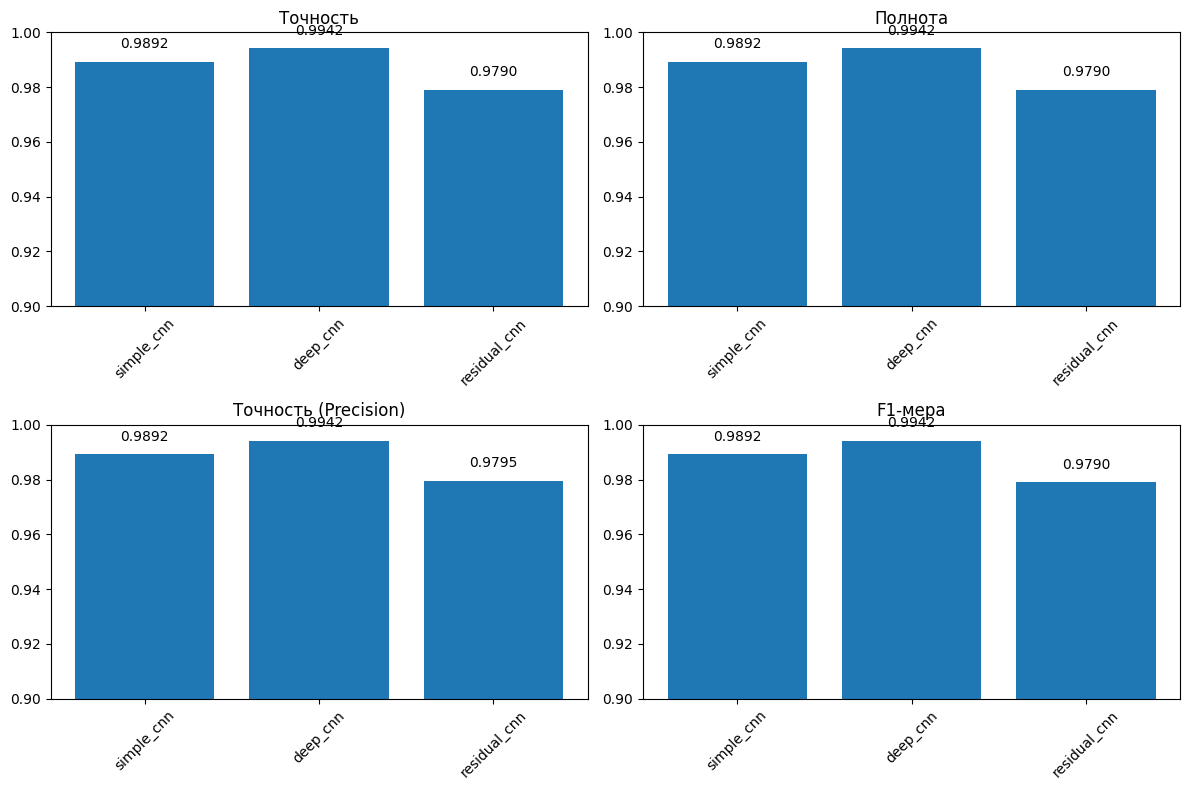

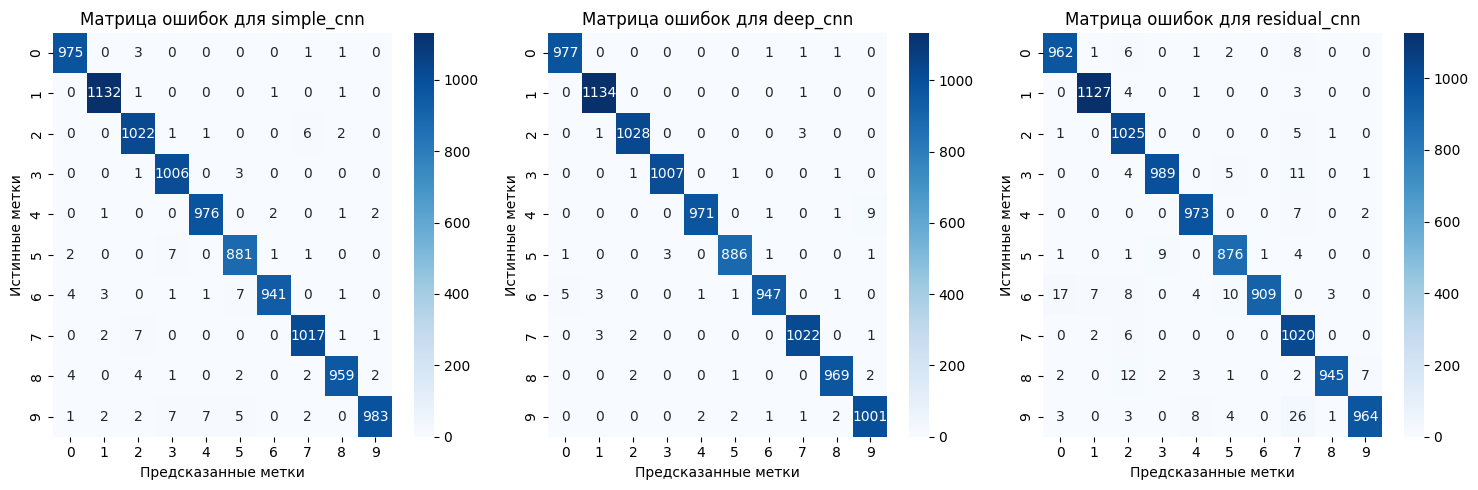


Лучшая модель по F1-мере: deep_cnn


In [ ]:
import pandas as pd

# Создание датафрейма с результатами
results_df = pd.DataFrame({
    model_name: {
        'Точность': metrics['accuracy'],
        'Полнота': metrics['recall'],
        'Точность (Precision)': metrics['precision'],
        'F1-мера': metrics['f1'],
        'Время обучения (сек)': metrics['training_time']
    }
    for model_name, metrics in results.items()
})

# Транспонирование для удобного отображения
results_df = results_df.T

# Сортировка по F1-мере
results_df_sorted = results_df.sort_values('F1-мера', ascending=False)

# Вывод результатов
print("Результаты по всем моделям:")
display(results_df_sorted.style.format("{:.4f}"))

# Визуализация метрик
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Точность', 'Полнота', 'Точность (Precision)', 'F1-мера']

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    plt.bar(results_df.index, results_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.ylim([0.9, 1.0])  # Настройка для лучшей визуализации различий

    # Добавление значений к барам
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.005, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Визуализация матриц ошибок
plt.figure(figsize=(15, 5))
for i, (name, metrics) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок для {name}')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')

plt.tight_layout()
plt.show()

# Выбор лучшей модели по F1-мере
best_model_name = results_df_sorted.index[0]
best_model = models[best_model_name]

print(f"\nЛучшая модель по F1-мере: {best_model_name}")

## **7. Сохранение лучшей модели в формате Keras**

In [ ]:
# Создаем директорию для сохранения модели
model_path = "best_classification_model.h5"

# Сохраняем модель в формате h5
best_model.save(model_path)

# Сохраняем краткое описание модели
best_model.summary()

Model: "deep_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,034,432 (19.20 MB)

 Trainable params: 1,677,674 (6.40 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 3,355,350 (12.80 MB)

## **8. Загрузка и использование сохраненной модели**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
Пример использования загруженной модели:
Изображение 1: Предсказанный класс = 7, Фактический класс = 7
Изображение 2: Предсказанный класс = 2, Фактический класс = 2
Изображение 3: Предсказанный класс = 1, Фактический класс = 1
Изображение 4: Предсказанный класс = 0, Фактический класс = 0
Изображение 5: Предсказанный класс = 4, Фактический класс = 4


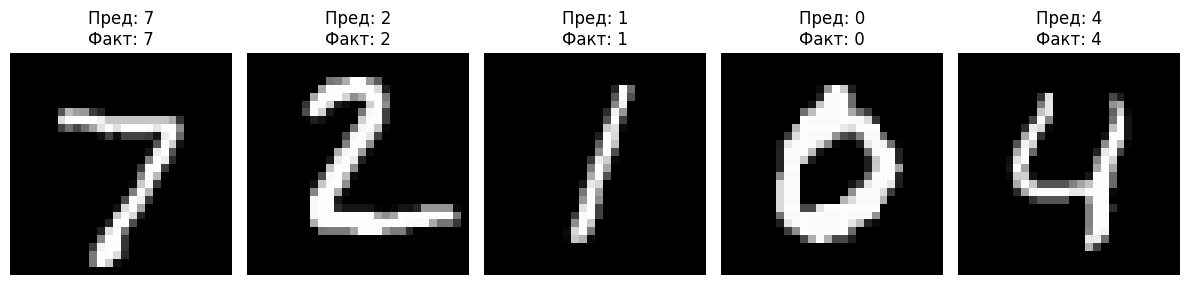

In [ ]:
# Загрузка модели
loaded_model = keras.models.load_model(model_path, compile=False)

# Пример использования модели на тестовых данных
test_sample = test_images[0:5]  # Взять первые 5 изображений из тестового набора

# Получение предсказаний
predictions = loaded_model.predict(test_sample)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(test_labels_cat[0:5], axis=1)

print("Пример использования загруженной модели:")
for i in range(len(test_sample)):
    print(f"Изображение {i+1}: Предсказанный класс = {predicted_classes[i]}, Фактический класс = {actual_classes[i]}")

# Визуализация примеров и предсказаний
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_sample[i].reshape(28, 28), cmap='gray')
    plt.title(f"Пред: {predicted_classes[i]}\nФакт: {actual_classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## **9. Реализация веб-приложения с использованием Gradio для работы с моделью**

In [1]:
%%capture
!pip install gradio

In [19]:
import gradio as gr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Загрузка модели
model_path = "best_classification_model.h5"
loaded_model = tf.keras.models.load_model(model_path, compile=False)

# Функция для предобработки изображения
def preprocess_image(image):
    # Проверка на пустое изображение
    if image is None:
        return None

    # Преобразование в оттенки серого, если изображение цветное
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = np.mean(image, axis=2)

    # Сохраним копию для отображения
    display_image = image.copy()

    # Инвертирование изображения, если оно имеет белые цифры на черном фоне
    # MNIST обучен на черных цифрах на белом фоне
    mean_value = np.mean(image)
    if mean_value > 0.5:  # Больше белых пикселей чем черных
        image = 1.0 - image

    # Изменение размера до 28x28
    image = tf.image.resize(tf.expand_dims(image, -1), [28, 28])

    # Нормализация значений пикселей до диапазона [0, 1]
    image = image / 255.0

    # Добавление размерности батча
    image = tf.expand_dims(image, 0)

    return image, display_image

# Функция для визуализации вероятностей
def create_probability_plot(probabilities):
    fig, ax = plt.subplots(figsize=(8, 5))
    digits = list(range(10))
    probs = [probabilities[str(i)] for i in digits]

    # Горизонтальные полосы для вероятностей
    bars = ax.barh(digits, probs, color='skyblue')

    # Добавление значений вероятностей
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.1%}',
                ha='left', va='center')

    # Настройка графика
    ax.set_xlabel('Вероятность')
    ax.set_ylabel('Цифра')
    ax.set_title('Распределение вероятностей')
    ax.set_xlim(0, 1.1)
    ax.set_yticks(digits)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig

# Функция для классификации
def classify_image(image):
    if image is None:
        return None, None

    # Предобработка изображения
    processed_image, display_image = preprocess_image(image)

    # Получение предсказаний
    predictions = loaded_model.predict(processed_image)
    predicted_class = np.argmax(predictions[0])

    # Получение вероятностей для всех классов
    probabilities = {str(i): float(predictions[0][i]) for i in range(10)}

    # Создание графика вероятностей
    prob_chart = create_probability_plot(probabilities)

    # Формирование текста предсказания с уверенностью
    confidence = float(predictions[0][predicted_class])
    prediction_text = f"**Предсказанная цифра: {predicted_class}** (уверенность: {confidence:.2%})"

    return prediction_text, prob_chart

# Создание интерфейса Gradio
with gr.Blocks(title="Распознавание рукописных цифр MNIST") as demo:
    gr.Markdown("# Распознавание рукописных цифр MNIST")
    gr.Markdown("Загрузите изображение с цифрой от 0 до 9.")

    with gr.Row():
        # Левая колонка для ввода изображения
        with gr.Column(scale=1):
            # Холст для рисования с черным фоном и белой кистью
            image_input = gr.Image(
                image_mode="L",
                type="numpy"
            )
            clear_button = gr.Button("Очистить")

        # Правая колонка для вывода результатов
        with gr.Column(scale=1):
            prediction_output = gr.Markdown(label="Предсказание")
            probability_plot = gr.Plot(label="Вероятности для всех классов")

    # Обработчики событий
    image_input.change(
        classify_image,
        inputs=[image_input],
        outputs=[prediction_output, probability_plot]
    )

    clear_button.click(
        lambda: (None, None, None),
        inputs=None,
        outputs=[image_input, prediction_output, probability_plot]
    )


# Запуск интерфейса
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://48ed9e4f4daad4b1a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **10. Развертывание модели Keras на сервере с использованием FastAPI**

**(Происходит по аналогии с предыдущим разделом, ниже приведен пример кода основных элементов кода, для того чтобы показать как работать конкретно с изображениями)**

**Разработка веб-приложения для классификации изображений с использованием обученной модели**

Процесс разработки веб-приложения, которое будет являться интерфейсом для обученной модели классификации изображений, включает в себя несколько этапов:

1. **Разработка и развёртывание API на платформе Render.com**
2. **Создание графического интерфейса с использованием Streamlit**
3. **Развёртывание приложения Streamlit на платформе Streamlit**

Рассмотрим каждый из этих этапов, а также прокомментируем предоставленный код модулей `app.py` и `main.py`.

Все этапы проводятся в десткопной среде Pycharm/VS Code, затем готовый проект пушится на GitHub

### **1. Разработка и развёртывание API на платформе Render.com**


#### **Файл `main.py`**

```python
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
import tensorflow as tf
import numpy as np
from PIL import Image
import io

app = FastAPI()

# Загрузка модели
model_path = "best_keras_classification_model"
model = tf.keras.models.load_model(model_path)
```

- **Импорт необходимых модулей:**
  - `FastAPI` для создания веб-приложения API.
  - `UploadFile`, `File` из `fastapi` для работы с загрузкой файлов.
  - `JSONResponse` для формирования структурированных JSON-ответов.
  - `tensorflow` для работы с нейронной сетью.
  - `numpy` для операций с массивами данных.
  - `PIL.Image` для обработки изображений.
  - `io` для работы с байтовыми потоками.

- **Создание экземпляра приложения:**
  - `app = FastAPI()` инициализирует экземпляр приложения FastAPI.

- **Загрузка модели:**
  - Указываем путь к директории `best_keras_classification_model`, содержащей сохранённую модель TensorFlow.
  - Используем `tf.keras.models.load_model` для загрузки предварительно обученной модели нейронной сети.

```python
def preprocess_image(image):
    # Преобразование в оттенки серого, если цветное изображение
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = np.mean(image, axis=2)
    
    # Изменение размера до 28x28
    image = tf.image.resize(tf.expand_dims(image, -1), [28, 28])
    
    # Нормализация значений пикселей [0, 1]
    image = image / 255.0
    
    # Добавление размерности батча
    image = tf.expand_dims(image, 0)
    
    return image
```

- **Функция `preprocess_image`:**
  - **Цель:** Подготовить изображение для подачи в нейронную сеть.
  
  - **Преобразование в оттенки серого:**
    - Проверяем формат изображения и преобразуем цветное изображение в оттенки серого, усредняя значения по каналам.
  
  - **Изменение размера:**
    - Используем `tf.image.resize` для изменения размера изображения до 28x28 пикселей (стандартный размер для MNIST).
    - Предварительно добавляем канальную размерность с помощью `tf.expand_dims`.
  
  - **Нормализация:**
    - Делим все значения пикселей на 255.0 для приведения к диапазону [0, 1].
  
  - **Подготовка входа для модели:**
    - Добавляем размерность батча, чтобы модель могла обработать одно изображение как мини-батч.
  
  - **Возвращаемые значения:**
    - Функция возвращает предобработанное тензорное представление изображения, готовое для подачи в нейронную сеть.

```python
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    # Чтение содержимого файла
    contents = await file.read()
    
    # Открытие изображения
    image = Image.open(io.BytesIO(contents))
    image_array = np.array(image)
    
    # Предобработка изображения
    processed_image = preprocess_image(image_array)
    
    # Получение предсказаний
    predictions = model.predict(processed_image)
    predicted_class = int(np.argmax(predictions[0]))
    
    # Вычисление вероятностей для каждого класса
    probabilities = [float(p) for p in predictions[0]]
    
    return JSONResponse(content={
        "predicted_class": predicted_class,
        "probabilities": probabilities
    })
```

- **Создание эндпоинта `/predict/`:**
  - Декоратор `@app.post("/predict/")` указывает на обработку POST-запросов по указанному адресу.
  - Функция `predict` принимает файл изображения через параметр `file`.

- **Обработка загруженного файла:**
  - Асинхронно читаем содержимое загруженного файла с помощью `await file.read()`.
  - Открываем изображение, используя `Image.open(io.BytesIO(contents))`, где `BytesIO` позволяет работать с байтовыми данными как с файловым объектом.
  - Преобразуем изображение в массив NumPy для дальнейшей обработки.

- **Предобработка и классификация:**
  - Вызываем функцию `preprocess_image` для подготовки изображения.
  - Подаём обработанное изображение в модель с помощью `model.predict`.
  - Определяем класс с наибольшей вероятностью, используя `np.argmax`.
  - Формируем список вероятностей для всех классов, преобразуя их в тип `float` для корректной JSON-сериализации.

- **Возвращение результата:**
  - Возвращаем JSON-ответ, содержащий:
    - `predicted_class` - предсказанный класс изображения (целое число).
    - `probabilities` - массив вероятностей принадлежности к каждому классу.

Создайте файл `requirements.txt`:

```
fastapi==0.103.0
numpy
tensorflow==2.18.0
uvicorn==0.23.2
scikit-learn==1.6.1
streamlit
opencv-python
matplotlib
streamlit_drawable_canvas
```

Для запуска API локально выполните:

```
uvicorn main:app --reload
```


**Развёртывание на Render.com:**

- **Шаги:**
  1. **Репозиторий проекта:**
     - Создайте репозиторий на GitHub, содержащий файлы `main.py`, `requirements.txt`, `best_classification_model` и `scaler.pkl` (при наличии).

  2. **Регистрация на Render.com:**
     - Зарегистрируйтесь на [Render.com](https://render.com/).

  3. **Создание нового веб-сервиса:**
     - В панели управления Render.com создайте новый веб-сервис, связав его с вашим репозиторием.

  4. **Настройка сервисного настроения:**
     - Укажите команду запуска приложения: `uvicorn main:app --host 0.0.0.0 --port 8000`.
     - Убедитесь, что в `requirements.txt` перечислены все необходимые зависимости.

  5. **Развёртывание:**
     - Запустите процесс развёртывания и дождитесь его завершения.
     - После успешного развёртывания ваш API будет доступен по выделенному адресу.

### **2. Создание графического интерфейса с использованием Streamlit**


#### **Описание файла `app.py` для классификации изображений**

```python
# Импорт необходимых библиотек
import streamlit as st
import requests
from PIL import Image
import io
import numpy as np
from streamlit_drawable_canvas import st_canvas
```

- **Импорт необходимых библиотек:**
  - `streamlit` для создания интерактивного веб-интерфейса.
  - `requests` для выполнения HTTP-запросов к API.
  - `PIL.Image` для обработки изображений.
  - `io` для операций с байтовыми потоками.
  - `numpy` для работы с массивами данных.
  - `streamlit_drawable_canvas` для создания интерактивного холста для рисования.

```python
# Заголовок приложения
st.title("Классификация изображений")

# Опция для выбора режима ввода изображения
mode = st.radio("Выберите способ ввода изображения:", ("Нарисовать изображение", "Загрузить изображение"))
```

- **Настройка интерфейса:**
  - Создаём заголовок приложения с помощью `st.title`.
  - Добавляем переключатель режимов с помощью `st.radio`, который позволяет пользователю выбрать между рисованием и загрузкой изображения.

```python
# Функция для отправки изображения на сервер и получения предсказания
def get_prediction(image_data):
    """
    Отправляет изображение на сервер FastAPI и возвращает предсказание.
    """
    try:
        # Отправка POST-запроса с изображением
        response = requests.post(
            "https://dpo-classification.onrender.com/predict/",
            files={"file": ("image.png", image_data, "image/png")}
        )
        response.raise_for_status()
        data = response.json()
        # Получаем predicted_class вместо prediction
        return data["predicted_class"]
    except requests.exceptions.RequestException as e:
        st.error(f"Ошибка при отправке запроса: {e}")
    except ValueError as e:
        st.error(f"Ошибка при обработке ответа: {e}")
    return None
```

- **Функция для взаимодействия с API:**
  - Определяем функцию `get_prediction`, которая отправляет изображение на сервер и получает результат классификации.
  - Используем блок `try-except` для обработки возможных ошибок при отправке запроса или обработке ответа.
  - Отправляем POST-запрос к API с изображением в формате multipart/form-data.
  - Проверяем статус ответа с помощью `raise_for_status()`.
  - Преобразуем ответ в JSON-формат и извлекаем предсказанный класс.

```python
# Функция предобработки изображения перед отправкой на сервер
def preprocess_image_client(image):
    """
    Преобразует изображение в нужный формат перед отправкой
    """
    # Преобразуем в оттенки серого, если это цветное изображение
    if image.mode == 'RGBA':
        image = image.convert('L')
    elif image.mode == 'RGB':
        image = image.convert('L')
    
    # Изменяем размер до 28x28
    image = image.resize((28, 28), Image.LANCZOS)
    
    return image
```

- **Функция предобработки изображения:**
  - Определяем функцию `preprocess_image_client` для подготовки изображения перед отправкой на сервер.
  - Преобразуем изображение в оттенки серого, проверяя его текущий цветовой режим (RGBA или RGB).
  - Изменяем размер изображения до 28x28 пикселей с использованием алгоритма LANCZOS для качественного масштабирования.

```python
# Обработка режима "Загрузить изображение"
if mode == "Загрузить изображение":
    uploaded_file = st.file_uploader("Загрузите изображение", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        col1, col2 = st.columns(2)

        with col1:
            # Показываем оригинальное изображение
            original_image = Image.open(uploaded_file)
            st.image(original_image, caption="Загруженное изображение", use_container_width=True)
```

- **Режим загрузки изображения:**
  - Проверяем, выбран ли режим "Загрузить изображение".
  - Добавляем элемент `st.file_uploader` для загрузки изображений в форматах JPG, JPEG или PNG.
  - При успешной загрузке создаём двухколоночный макет с помощью `st.columns(2)`.
  - В первой колонке отображаем оригинальное загруженное изображение.

```python
        # Предобрабатываем изображение перед отправкой
        processed_image = preprocess_image_client(original_image)
        
        # Для отладки можно показать обработанное изображение
        # st.image(processed_image, caption="Обработанное изображение (28x28)", width=56)
        
        # Преобразование в байты для отправки
        img_byte_arr = io.BytesIO()
        processed_image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()

        # Получение предсказания
        prediction = get_prediction(img_byte_arr)
```

- **Обработка и отправка загруженного изображения:**
  - Вызываем функцию предобработки изображения перед отправкой.
  - Преобразуем обработанное изображение в байтовый формат для отправки:
    - Создаём байтовый буфер с помощью `io.BytesIO()`.
    - Сохраняем изображение в буфер в формате PNG.
    - Получаем байтовое представление с помощью `getvalue()`.
  - Отправляем изображение на сервер и получаем предсказание с помощью функции `get_prediction()`.

```python
        if prediction is not None:
            with col2:
                st.markdown(
                    f"<div style='display: flex; align-items: center; justify-content: center; height: 100%;'>"
                    f"<h1 style='font-size: 48px;'>{prediction}</h1>"
                    f"</div>",
                    unsafe_allow_html=True
                )
```

- **Отображение результата классификации:**
  - Проверяем, успешно ли получено предсказание.
  - Во второй колонке отображаем результат классификации в виде крупного текста.
  - Используем HTML-разметку через `st.markdown` с параметром `unsafe_allow_html=True` для центрирования и стилизации результата.

```python
# Обработка режима "Нарисовать изображение"
elif mode == "Нарисовать изображение":
    stroke_width = st.slider("Толщина линии:", 1, 25, 9)
    
    col_color1, col_color2 = st.columns(2)
    with col_color1:
        stroke_color = st.color_picker("Цвет линии:", "#FFFFFF")
    with col_color2:
        bg_color = st.color_picker("Цвет фона:", "#000000")

    realtime_update = st.checkbox("Обновлять в реальном времени", True)
```

- **Настройка холста для рисования:**
  - Проверяем, выбран ли режим "Нарисовать изображение".
  - Добавляем ползунок для выбора толщины линии с помощью `st.slider`.
  - Создаём двухколоночный макет для элементов выбора цвета.
  - Добавляем выбор цвета линии и фона с помощью `st.color_picker`.
  - Добавляем флажок для включения/отключения обновления в реальном времени.

```python
    col1, col2 = st.columns(2)

    with col1:
        canvas_result = st_canvas(
            fill_color="rgba(0, 0, 0, 0)",
            stroke_width=stroke_width,
            stroke_color=stroke_color,
            background_color=bg_color,
            update_streamlit=realtime_update,
            height=280,
            width=280,
            drawing_mode="freedraw",
            key="canvas",
        )
```

- **Создание интерактивного холста:**
  - Создаём двухколоночный макет для холста и результата.
  - В первой колонке размещаем холст для рисования с помощью `st_canvas`.
  - Настраиваем параметры холста:
    - Цвет заливки (прозрачный).
    - Толщина и цвет линии на основе выбора пользователя.
    - Цвет фона на основе выбора пользователя.
    - Размеры холста (280x280 пикселей).
    - Режим рисования "freedraw" для свободного рисования от руки.

```python
    if canvas_result.image_data is not None:
        # Преобразование данных холста в изображение
        original_image = Image.fromarray(canvas_result.image_data.astype('uint8'), 'RGBA')
        
        # Предобрабатываем изображение перед отправкой
        processed_image = preprocess_image_client(original_image)
        
        # Преобразование в байты для отправки
        img_byte_arr = io.BytesIO()
        processed_image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()

        # Получение предсказания
        prediction = get_prediction(img_byte_arr)
```

- **Обработка и отправка нарисованного изображения:**
  - Проверяем, содержит ли холст данные изображения.
  - Преобразуем данные холста в объект изображения с помощью `Image.fromarray()`.
  - Вызываем функцию предобработки изображения.
  - Преобразуем обработанное изображение в байтовый формат для отправки.
  - Отправляем изображение на сервер и получаем предсказание.

```python
        if prediction is not None:
            with col2:
                st.markdown(
                    f"<div style='display: flex; align-items: center; justify-content: center; height: 280px;'>"
                    f"<h1 style='font-size: 48px;'>{prediction}</h1>"
                    f"</div>",
                    unsafe_allow_html=True
                )
```

- **Отображение результата классификации для нарисованного изображения:**
  - Проверяем, успешно ли получено предсказание.
  - Во второй колонке отображаем результат классификации в виде крупного текста.
  - Используем HTML-разметку для центрирования и стилизации результата, соответствующего размеру холста (высота 280px).

Для запуска Streamlit приложения локально выполните:

```
streamlit run app.py
```

### **Структура репозитория с проектом**



```
app.py
main.py
requirements.txt
best_classification_model.h5
```

- **`app.py`** — код клиентского приложения Streamlit.
- **`main.py`** — код серверного приложения FastAPI.
- **`requirements.txt`** — файл зависимостей для API.
- **`best_classification_model`** — файл с сохранённой моделью классификации.
